# Plot ensemble mean performance of three tramsfer learning models (tDPL-a, tDPL-b, tDPL-c) for comparison.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from ensembleUtils import Evaluator
import seaborn as sns
import pandas as pd

## Get metrics for streamflow, ET and snow depth for each model during 2000-2019

In [2]:
rootDir = '../checkpoints/Types'
meanOpt = True  # determine whether plot mean performance for ET and snow depth
modelNames = ['TL-a', 'TL-b', 'TL-c', 'TL-d']
stations = ['TNH', 'JUG', 'MAQ', 'MET', 'JIM']
#  initiate a dict to store NSE, r, and PBIAS of streamflow, r and RMSE of ET and snow depth for five models
modelMetric = defaultdict(dict)
for model in modelNames:
    print(f'Calculating metrics for model {model}')
    modelDir = os.path.join(rootDir, model)
    evaluator = Evaluator(ensembleFolder=modelDir,
                          basinFile='../data/sub-basins/watershed.shp',
                          flowFile='../data/streamflow.csv',
                          valDataFile='../data/valData.pkl',
                          modelTyp='tDPL')
    modelMetric[model] = evaluator.metric
seeds = [k for k in modelMetric[modelNames[0]]['Q'].keys() if k is not 'mean']

Calculating metrics for model TL-a
Calculating metrics for model TL-b
Calculating metrics for model TL-c
Calculating metrics for model TL-d


### Plot box diagram for streamflow

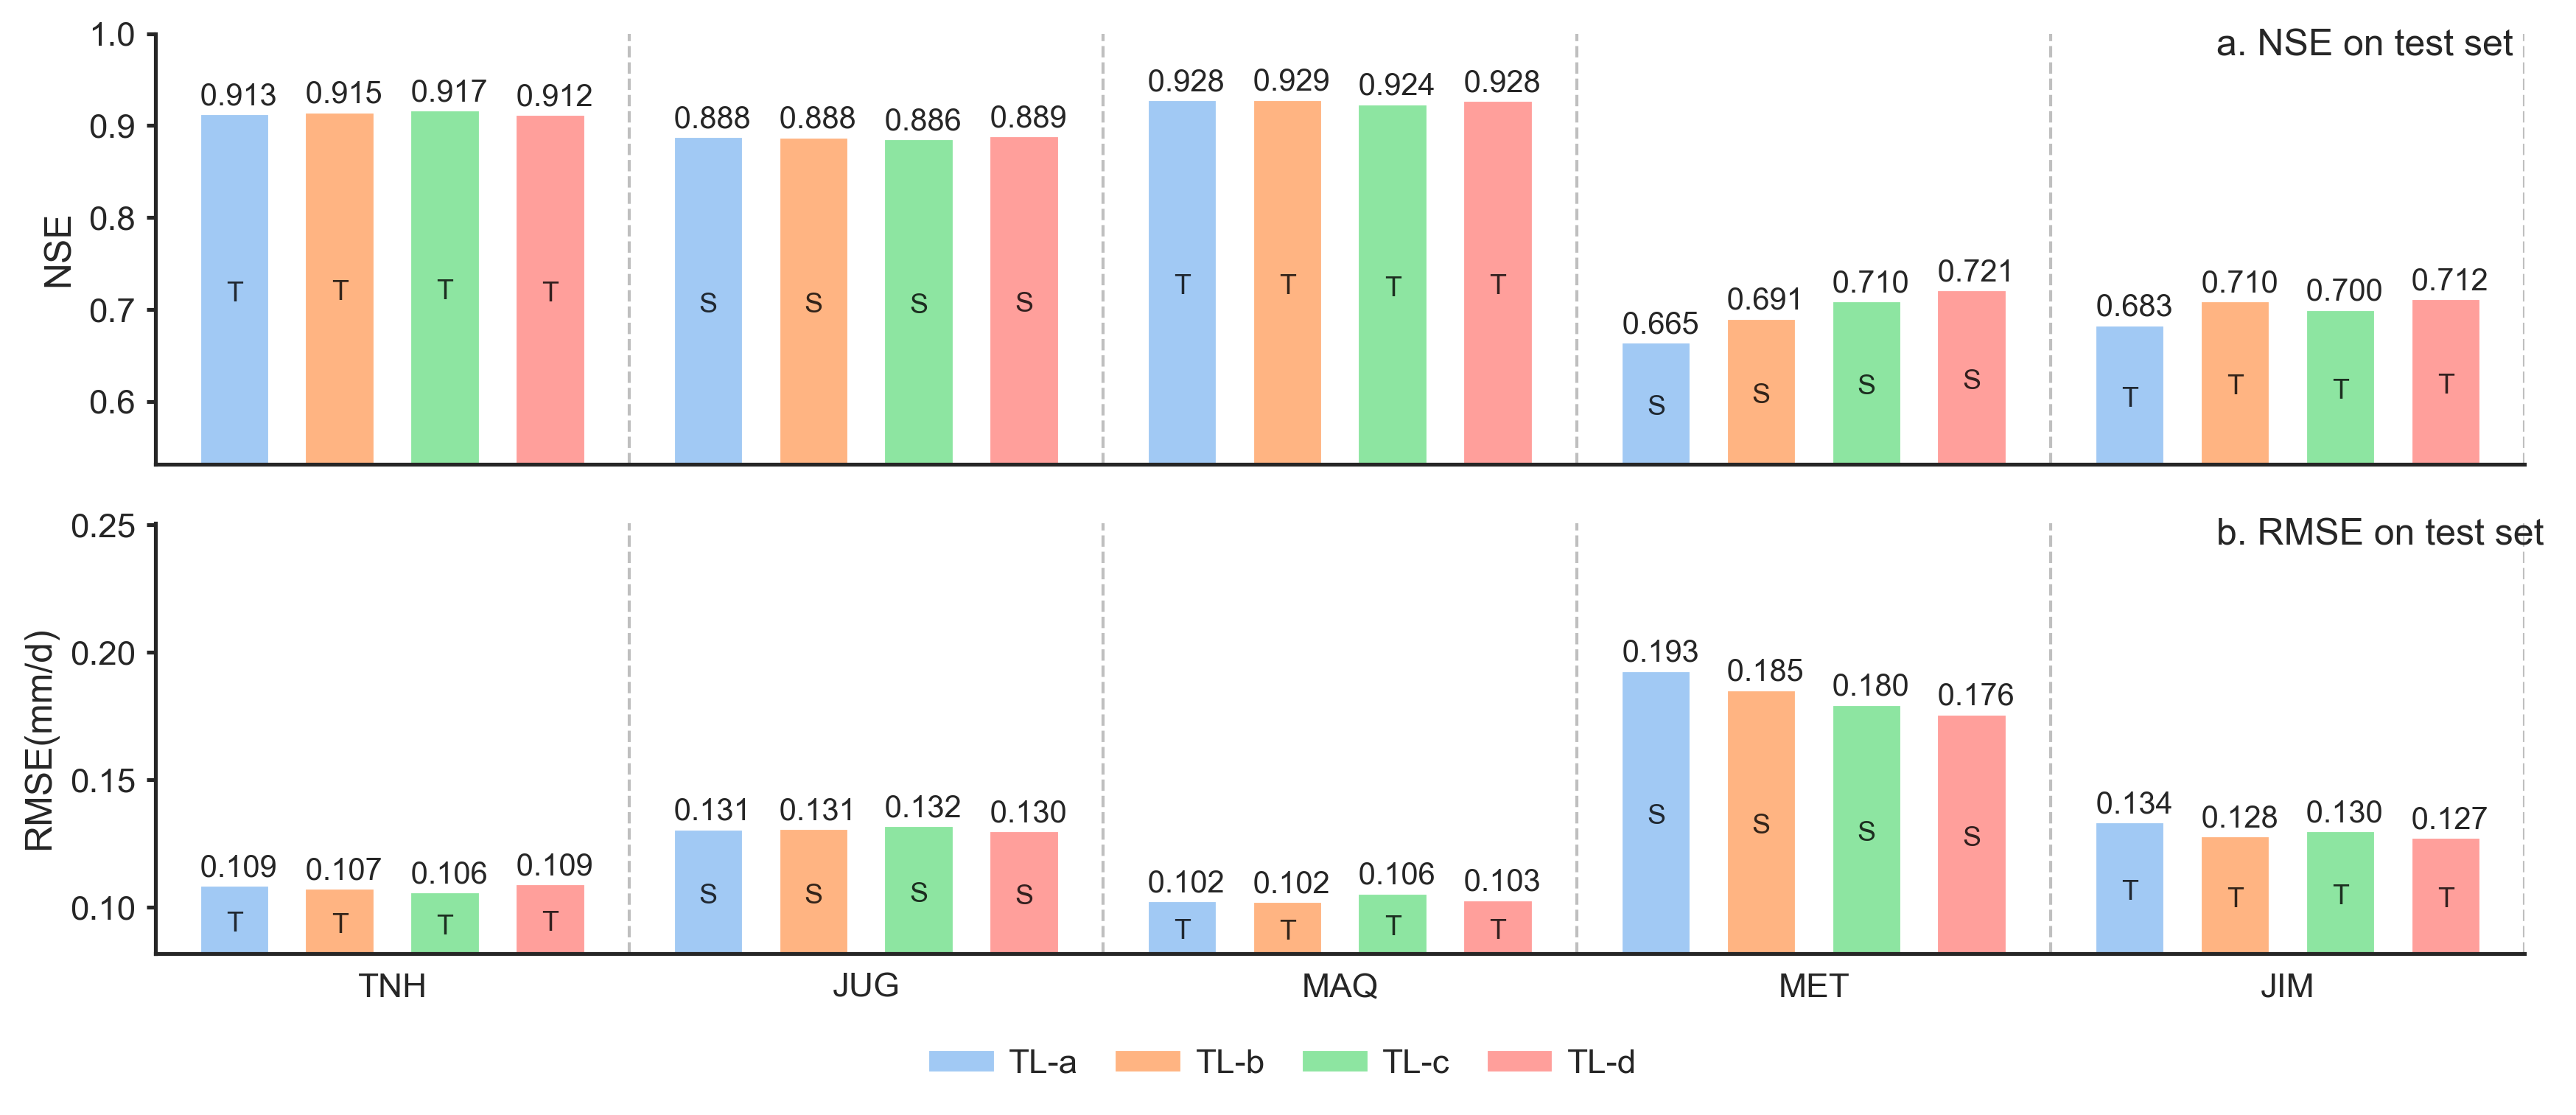

In [4]:
plt.rcParams['font.family'] = 'Arial'
sns.set(style="ticks")

def auto_text(rects, ax, metric):
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            xy=(rect.get_x() + rect.get_width() / 2, height)
        else:
            xy=(rect.get_x() + rect.get_width() / 2, 0)

        text = f'{height: .1f}' if metric in ['PBIAS'] else f'{height: .3f}'
        ax.annotate(text,  # put the detail data
                    xy=xy,  # get the center location.
                    xytext=(0, 1),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

fig = plt.figure(figsize=(12, 5), dpi=300)

# 'T' indicates temporal test station, 'S' indicates spatial test stations
markers = {
    'TL-a': {'TNH': 'T', 'MAQ': 'T', 'JIM': 'T', 'MET': 'S', 'JUG': 'S'},
    'TL-b': {'TNH': 'T', 'MAQ': 'T', 'JIM': 'T', 'MET': 'S', 'JUG': 'S'},
    'TL-c': {'TNH': 'T', 'MAQ': 'T', 'JIM': 'T', 'MET': 'S', 'JUG': 'S'},
    'TL-d': {'TNH': 'T', 'MAQ': 'T', 'JIM': 'T', 'MET': 'S', 'JUG': 'S'}
}
metricUnit = dict(zip(['NSE', 'RMSE'], ['', '(mm/d)']))

colors = dict(zip(markers.keys(), [c for c in sns.color_palette('pastel', n_colors=4)]))

for i, metricName in enumerate(metricUnit.keys()):
    yMax, yMin = -9999, 9999
    ax = fig.add_subplot(2, 1, i + 1)
    boxes = defaultdict()
    space, width = 0.1, 0.2
    for k, station in enumerate(stations):
        for j, model in enumerate(markers.keys()):
            xTemp = np.array([(space + width) * (0.5 + j + k * 4) + space * k * 1.5])
            yTemp = np.array([modelMetric[model]['Q']['mean'][station][metricName]])
            yMax = yTemp.max() if yTemp.max() > yMax else yMax
            yMin = yTemp.min() if yTemp.min() < yMin else yMin
            rect = ax.bar(xTemp, yTemp, width, color=colors[model], label=model)
            auto_text(rect, ax, metricName)

    # ax.set_xlabel(station, labelpad=2.5)
    top = min(yMax * 1.6, 1.0) if metricName in ['NSE', 'r', 'KGE'] else yMax * 1.3
    bottom = yMin * 0.8 if yMin > 0 else yMin * 1.3
    ax.set_ylim(top=top, bottom=bottom)
    xticks = [(space + width) * (2 + k * 4) + space * k * 1.5 for k in range(len(stations))]
    if i == 1:
        ax.set_xticks(xticks)
        ax.set_xticklabels(stations)
    else:
        ax.set_xticks([])

    # add scatter plot
    for k, station in enumerate(stations):
        for j, model in enumerate(markers.keys()):
            xScatter = (space + width) * (0.5 + j + k * 4) + space * k * 1.5
            yScatter = modelMetric[model]['Q']['mean'][station][metricName]
            yScatter = (yScatter - max(bottom, 0)) * 0.5 + max(bottom, 0)
            ax.annotate(markers[model][station], xy=(xScatter, yScatter), xytext=(0, -1.5), ha='center', va='center', fontsize=9, color='black', textcoords='offset points', alpha=0.8)
            if j == 3:
                ax.axvline(x=xScatter + 1.25 * space + width / 2, color='grey', linestyle='--', alpha=0.5, linewidth=1)

    ax.tick_params(axis='y', length=3)  # adjust tick length
    ax.tick_params(axis='x', length=3, color='white')  # adjust tick length
    ax.set_ylabel(metricName + metricUnit[metricName])
    ax.set_xlim(left=xticks[0] - 2 * (width + space) - 0.75 * space, right=xticks[-1] + 2 * (width + space) + 0.75 * space)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.grid(axis='y',ls='--',alpha=0.8)
    ax.annotate(f'{chr(97 + i)}. {metricName} on test set ', xy=(0.87, 0.95), xycoords='axes fraction')

lines, labels = ax.get_legend_handles_labels()
fig.legend(lines[:4], labels[:4], ncol=4, borderaxespad=0.1,
           bbox_to_anchor=(0.35, 0.03, 0.28, 0.02), mode='expand', columnspacing=1, frameon=False, handletextpad=0.4)

fig.tight_layout(rect=(0, 0.04, 1, 1))
plt.savefig(f'{rootDir}/runoff_TL.jpg')